
📋 Vergleich der Prognosegüte zwischen Baseline und 90er-Regel:


,Monat,MAE_Baseline,RMSE_Baseline,Under_Baseline,Over_Baseline,MAE_90,RMSE_90,Under_90,Over_90
0,February,55.92,99.97,0.18,0.82,95.00,116.20,0.07,0.93
1,March,111.39,168.56,0.42,0.58,124.03,155.30,0.39,0.61
2,April,200.67,315.69,0.57,0.43,205.77,300.67,0.47,0.53
3,Durchschnitt,122.66,194.74,0.39,0.61,141.60,190.72,0.31,0.69


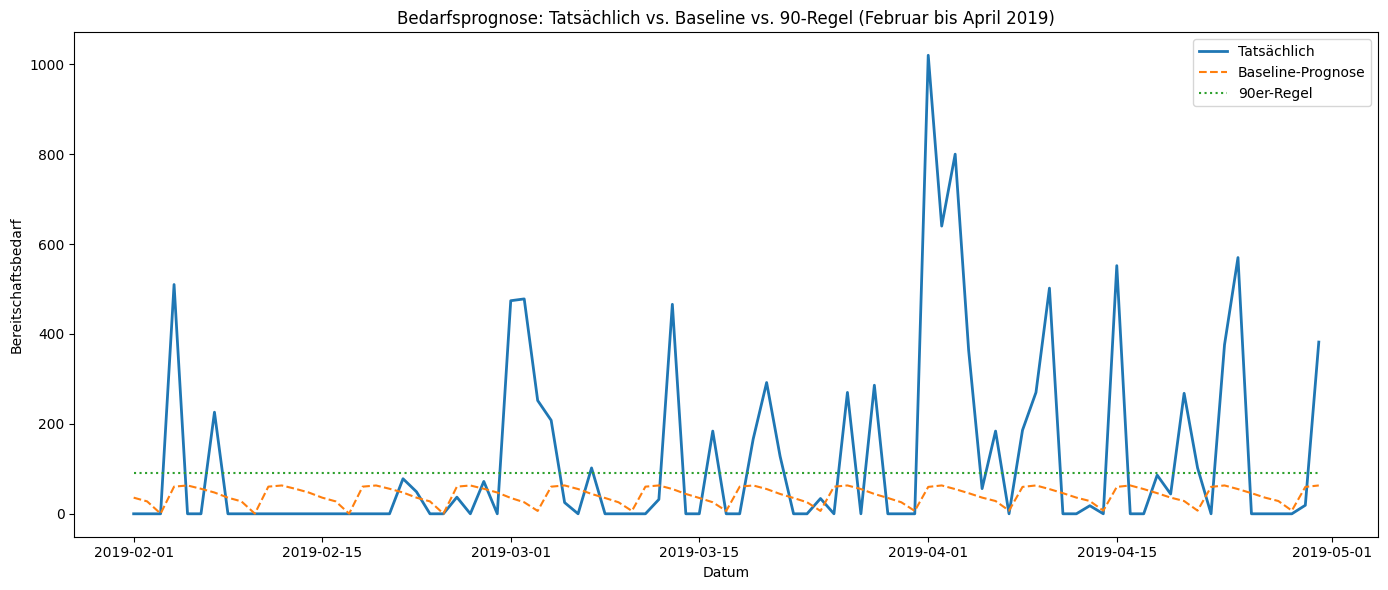

In [16]:
# 03_model_baseline.ipynb

import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from IPython.display import display

# --------------------------------------
# 1. Daten laden
# --------------------------------------
pfad = os.path.abspath("../data/processed/sickness_table.parquet")
df = pd.read_parquet(pfad)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')

# --------------------------------------
# 2. Monatsweise Vorhersagefunktion
# --------------------------------------
def predict_for_month(df, vorhersagedatum):
    forecast_start = (vorhersagedatum + pd.offsets.MonthBegin(1)).replace(day=1)
    forecast_end = forecast_start + pd.offsets.MonthEnd(0)
    forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="D")

    # Trainingsdaten bis zum 15. des Vormonats
    df_train = df.loc[:vorhersagedatum].copy()

    # Rolling-Median der calls je Wochentag
    calls_by_weekday = df_train.groupby(df_train.index.weekday)["calls"].median()

    # Forecast vorbereiten
    df_forecast = pd.DataFrame(index=forecast_dates)
    df_forecast["weekday"] = df_forecast.index.weekday
    df_forecast["calls_pred"] = df_forecast["weekday"].map(calls_by_weekday)

    # Regression: target_bereitschaft ~ calls + weekday
    df_train["weekday"] = df_train.index.weekday
    X_train = df_train[["calls", "weekday"]]
    y_train = df_train["target_bereitschaft"]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Vorhersage für target_bereitschaft
    X_forecast = df_forecast[["calls_pred", "weekday"]].copy()
    X_forecast.columns = ["calls", "weekday"]
    df_forecast["target_pred"] = model.predict(X_forecast)

    # Wahre Werte und 90er-Regel ergänzen
    df_eval = df.loc[forecast_start:forecast_end].copy()
    df_forecast = df_forecast.join(df_eval, how="left", rsuffix="_eval")
    df_forecast["target_true"] = df_eval["target_bereitschaft"]
    df_forecast["target_90_rule"] = 90
    df_forecast["abs_error"] = (df_forecast["target_pred"] - df_forecast["target_true"]).abs()

    return df_forecast

# --------------------------------------
# 3. Evaluation Februar – April 2019
# --------------------------------------
monate = ["2019-01-15", "2019-02-15", "2019-03-15"]
alle_ergebnisse = []

for vdatum in monate:
    df_monat = predict_for_month(df, pd.Timestamp(vdatum))

    # Baseline
    mae_b = mean_absolute_error(df_monat["target_true"], df_monat["target_pred"])
    rmse_b = sqrt(mean_squared_error(df_monat["target_true"], df_monat["target_pred"]))
    under_b = (df_monat["target_pred"] < df_monat["target_true"]).sum() / len(df_monat)
    over_b = (df_monat["target_pred"] > df_monat["target_true"]).sum() / len(df_monat)

    # 90er-Regel
    mae_90 = mean_absolute_error(df_monat["target_true"], df_monat["target_90_rule"])
    rmse_90 = sqrt(mean_squared_error(df_monat["target_true"], df_monat["target_90_rule"]))
    under_90 = (df_monat["target_90_rule"] < df_monat["target_true"]).sum() / len(df_monat)
    over_90 = (df_monat["target_90_rule"] > df_monat["target_true"]).sum() / len(df_monat)

    monat = (pd.Timestamp(vdatum) + pd.DateOffset(months=1)).strftime("%B")
    alle_ergebnisse.append({
        "Monat": monat,
        "MAE_Baseline": mae_b,
        "RMSE_Baseline": rmse_b,
        "Under_Baseline": under_b,
        "Over_Baseline": over_b,
        "MAE_90": mae_90,
        "RMSE_90": rmse_90,
        "Under_90": under_90,
        "Over_90": over_90,
        "df_monat": df_monat 
    })

# --------------------------------------
# 4. Metrikvergleich als Tabelle
# --------------------------------------
df_metrics = pd.DataFrame(alle_ergebnisse).drop(columns=["df_monat"])
df_avg = df_metrics.drop(columns=["Monat"]).mean().to_frame().T
df_avg["Monat"] = "Durchschnitt"
df_final = pd.concat([df_metrics, df_avg], ignore_index=True)

cols_order = [
    "Monat", "MAE_Baseline", "RMSE_Baseline", "Under_Baseline", "Over_Baseline",
    "MAE_90", "RMSE_90", "Under_90", "Over_90"
]
df_final = df_final[cols_order]

print("\n📋 Vergleich der Prognosegüte zwischen Baseline und 90er-Regel:")
display(df_final.round(2))

# --------------------------------------
# 5. Visualisierung & Speicherung
# --------------------------------------
alle_monate = pd.concat([eintrag["df_monat"] for eintrag in alle_ergebnisse])

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(alle_monate.index, alle_monate["target_true"], label="Tatsächlich", linewidth=2)
ax.plot(alle_monate.index, alle_monate["target_pred"], label="Baseline-Prognose", linestyle='--')
ax.plot(alle_monate.index, alle_monate["target_90_rule"], label="90er-Regel", linestyle=':')
ax.set_title("Bedarfsprognose: Tatsächlich vs. Baseline vs. 90-Regel (Februar bis April 2019)")
ax.set_ylabel("Bereitschaftsbedarf")
ax.set_xlabel("Datum")
ax.legend()
fig.tight_layout()

# 📦 Grafik speichern
fig_dir = os.path.abspath("../../reports/figures/baseline")
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, "baseline_forecast_feb_apr_2019.png")
fig.savefig(fig_path, dpi=300)

plt.show()

# --------------------------------------
# 6. Prognosedaten mit Features speichern
# --------------------------------------
prediction_output_path = os.path.abspath("../data/predictions/baseline.parquet")
os.makedirs(os.path.dirname(prediction_output_path), exist_ok=True)
alle_monate.to_parquet(prediction_output_path, index=True)
